## Load Raw Data into Train/Val/Test sets and Save
This also has the ability to write the raw data files into train/validate/test files.  These files only contain the raw TLE data.  Extra pre-processing is still required as well as the assembly of input/label data.

In [1]:
from load_data import *

In [2]:
norad_lists = load_norads(['train','validate','secret_test'])
df_dict = load_data(norad_lists, use_all_data=True, debug=True, multiproc=True)  # Takes about 4min

Loading files from path: C:\Datasets\gp_history


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Finished loading.


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.99s/it]

Finished assembling.


In [3]:
write_data(df_dict, use_all_data=True, debug=True, threaded=True)

Saving files to path: C:\Datasets\gp_history/raw_compiled
Writing raw data for to: C:\Datasets\gp_history/raw_compiled/train.pkl
Writing raw data for to: C:\Datasets\gp_history/raw_compiled/test.pklWriting raw data for to: C:\Datasets\gp_history/raw_compiled/secret_test.pkl

Finished saving C:\Datasets\gp_history/raw_compiled/secret_test.pkl
Finished saving C:\Datasets\gp_history/raw_compiled/test.pkl
Finished saving C:\Datasets\gp_history/raw_compiled/train.pkl


In [4]:
norad_lists = load_norads(['train','validate'])
df_dict = load_data(norad_lists, use_all_data=False, debug=True, multiproc=True)
write_data(df_dict, use_all_data=False, debug=True, threaded=True)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Loading files from path: C:\Users\mille\Documents\tle-prediction/data/space-track-gp-hist-sample


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 45.48it/s]

Finished loading.


Finished assembling.
Saving files to path: C:\Users\mille\Documents\tle-prediction/data/space-track-gp-hist-sample/raw_compiled
Writing raw data for to: C:\Users\mille\Documents\tle-prediction/data/space-track-gp-hist-sample/raw_compiled/train.pkl
Writing raw data for to: C:\Users\mille\Documents\tle-prediction/data/space-track-gp-hist-sample/raw_compiled/test.pkl
Finished saving C:\Users\mille\Documents\tle-prediction/data/space-track-gp-hist-sample/raw_compiled/test.pkl
Finished saving C:\Users\mille\Documents\tle-prediction/data/space-track-gp-hist-sample/raw_compiled/train.pkl


## Load Raw Train set and train/test a model

In [1]:
import pandas as pd
import numpy as np
import os

files = ['train']

model_cols = ['BSTAR', 'INCLINATION', 'RA_OF_ASC_NODE', 'ECCENTRICITY', 'ARG_OF_PERICENTER', 'MEAN_ANOMALY',
              'MEAN_MOTION', 'epoch_jd', 'epoch_fr',
              #'MEAN_MOTION_DOT', 'MEAN_MOTION_DDOT', 
             ]

#%time df = pd.read_pickle(os.environ['GP_HIST_PATH'] + '/raw_compiled/train.pkl' )  # Takes about 20s
train_df = pd.read_pickle(os.environ['my_home_path'] + '/data/space-track-gp-hist-sample/raw_compiled/train.pkl' )
test_df = pd.read_pickle(os.environ['my_home_path'] + '/data/space-track-gp-hist-sample/raw_compiled/test.pkl' )

In [2]:
train_df[model_cols[:-2]].head()

,BSTAR,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION
0,0.002592,62.2415,180.1561,0.070489,265.6761,86.2771,12.852684
1,0.000100,73.3600,345.6887,0.008815,270.3999,88.6911,12.642166
2,0.001076,83.0239,250.9465,0.008493,184.3222,175.7249,13.856401
3,0.000166,70.9841,207.4830,0.020756,161.3777,199.5075,13.715209
4,0.000739,90.1460,192.1834,0.002746,300.4617,59.3655,12.992417


In [3]:
%%time
import clean_data

for df in [train_df, test_df]:
    df = clean_data.add_epoch_data(df)
    df = clean_data.normalize_all_columns(df)
    
train_idx_map = clean_data.create_index_map(train_df)
test_idx_map = clean_data.create_index_map(test_df)

train_df = train_df[model_cols]
test_df = test_df[model_cols]

100%|██████████████████████████████████████████████████████████████████████████████| 599/599 [00:00<00:00, 1385.51it/s]

Wall time: 4.46 s


In [4]:
train_df.head()

,BSTAR,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION,epoch_jd,epoch_fr
0,0.051838,0.345786,0.500434,0.413086,0.737989,0.239659,-0.406934,2453122.5,0.596391
1,0.002000,0.407556,0.960246,0.206575,0.751111,0.246364,-0.502072,2453122.5,0.666444
2,0.021510,0.461244,0.697074,0.204030,0.512006,0.488125,0.046666,2453122.5,0.823075
3,0.003313,0.394356,0.576342,0.274821,0.448271,0.554187,-0.017142,2453122.5,0.654993
4,0.014780,0.500811,0.533843,0.140034,0.834616,0.164904,-0.343786,2453122.5,0.154908


In [5]:
import train

model = train.train_model(train_df, train_idx_map, batchSize=200, print_itr=100, numEpochs=5, model_cols=model_cols)

>>> Loading model
>>> Loading dataset
>>> Beginning training!
Epoch [1/5], Step [100/545], Loss: 10681.0888671875, Time: 1s
Epoch [1/5], Step [200/545], Loss: 4001.9326171875, Time: 1s
Epoch [1/5], Step [300/545], Loss: 829.184814453125, Time: 1s
Epoch [1/5], Step [400/545], Loss: 284.8900146484375, Time: 1s
Epoch [1/5], Step [500/545], Loss: 0.24430955946445465, Time: 1s
Epoch [2/5], Step [100/545], Loss: 0.18085017800331116, Time: 1s
Epoch [2/5], Step [200/545], Loss: 0.1888359934091568, Time: 1s
Epoch [2/5], Step [300/545], Loss: 0.18320360779762268, Time: 1s
Epoch [2/5], Step [400/545], Loss: 0.19605959951877594, Time: 1s
Epoch [2/5], Step [500/545], Loss: 0.18620724976062775, Time: 1s
Epoch [3/5], Step [100/545], Loss: 0.1825728863477707, Time: 1s
Epoch [3/5], Step [200/545], Loss: 0.20176973938941956, Time: 1s
Epoch [3/5], Step [300/545], Loss: 0.17267699539661407, Time: 1s
Epoch [3/5], Step [400/545], Loss: 0.18654005229473114, Time: 1s
Epoch [3/5], Step [500/545], Loss: 0.18197

In [6]:
model.eval()

NNModel(
  (activate): ReLU()
  (layer1): Linear(in_features=11, out_features=300, bias=True)
  (layer2): Linear(in_features=300, out_features=7, bias=True)
)

In [7]:
X_train,y_train = clean_data.build_xy(train_df,train_idx_map)  # create input/label pair

In [26]:
X_train.head()

,BSTAR,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION,epoch_jd,epoch_fr,epoch_jd_y,epoch_fr_y
0,0.031248,0.345776,0.326872,0.413411,0.754269,0.223581,-0.406661,2453148.5,0.347955,2452054.5,0.343767
1,-0.010632,0.345719,0.680316,0.423572,0.088902,0.923566,-0.433865,2452054.5,0.343767,2452045.5,0.433089
2,0.009629,0.345688,0.739830,0.423548,0.083611,0.928187,-0.433860,2452045.5,0.433089,2452050.5,0.357408
3,0.008059,0.345690,0.706918,0.423494,0.086567,0.925581,-0.433848,2452050.5,0.357408,2452047.5,0.387186
4,0.006959,0.345662,0.726755,0.423515,0.084929,0.927034,-0.433859,2452047.5,0.387186,2453123.5,0.607819


In [27]:
y_train.head()

,BSTAR,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION
0,-0.010632,0.345719,0.680316,0.423572,0.088902,0.923566,-0.433865
1,0.009629,0.345688,0.739830,0.423548,0.083611,0.928187,-0.433860
2,0.008059,0.345690,0.706918,0.423494,0.086567,0.925581,-0.433848
3,0.006959,0.345662,0.726755,0.423515,0.084929,0.927034,-0.433859
4,0.051196,0.345795,0.493620,0.413110,0.738555,0.239273,-0.406919


In [22]:
y_pred = train.predict(model, X_train) # get predictions for each train
y_pred_df = pd.DataFrame(y_pred, columns=train_df.columns[:-2])  # put results into a dataframe
clean_data.normalize_all_columns(y_pred_df, reverse=True)  # reverse the normalization

,BSTAR,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION
0,0.011917,0.4617,0.509508,0.218454,0.480358,0.520032,0.003095
1,0.011917,0.4617,0.509508,0.218454,0.480358,0.520032,0.003095
2,0.011917,0.4617,0.509508,0.218454,0.480358,0.520032,0.003095
3,0.011917,0.4617,0.509508,0.218454,0.480358,0.520032,0.003095
4,0.011917,0.4617,0.509508,0.218454,0.480358,0.520032,0.003095


## Distribution of Raw Columns

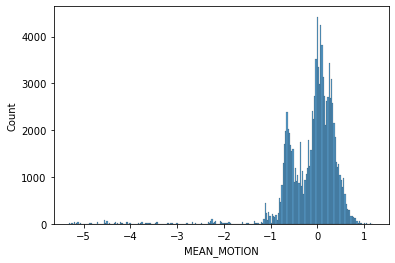

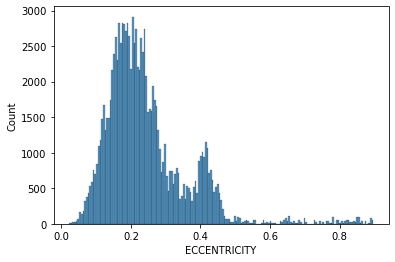

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df,x='MEAN_MOTION')
plt.show()

sns.histplot(df,x='ECCENTRICITY')
plt.show()

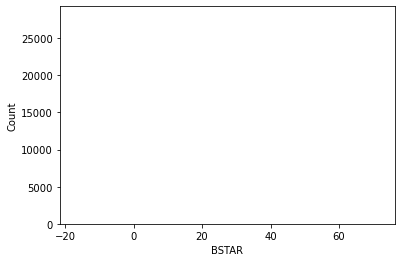

In [6]:
sns.histplot(df,x='BSTAR')
plt.show()

## Load Cleaned data

In [1]:
import pandas as pd
import os

files = ['train']
model_cols = ['MEAN_MOTION_DOT', 'MEAN_MOTION_DDOT', 'BSTAR', 'INCLINATION', 'RA_OF_ASC_NODE',
              'ECCENTRICITY', 'ARG_OF_PERICENTER', 'MEAN_ANOMALY', 'MEAN_MOTION', 'epoch_jd', 'epoch_fr']

%time df = pd.read_pickle(os.environ['GP_HIST_PATH'] + '/cleaned/train_clean.pkl')  # Takes about 20s

Wall time: 26.6 s


In [5]:
df[model_cols].head()

,MEAN_MOTION_DOT,MEAN_MOTION_DDOT,BSTAR,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION,epoch_jd,epoch_fr
0,1.801000e-05,0.0,0.002592,62.2415,180.1561,0.070489,265.6761,86.2771,12.852684,2453122.5,0.596391
1,-2.000000e-08,0.0,0.000100,73.3600,345.6887,0.008815,270.3999,88.6911,12.642166,2453122.5,0.666444
2,1.280000e-05,0.0,0.001076,83.0239,250.9465,0.008493,184.3222,175.7249,13.856401,2453122.5,0.823075
3,1.320000e-06,0.0,0.000166,70.9841,207.4830,0.020756,161.3777,199.5075,13.715209,2453122.5,0.654993
4,2.280000e-06,0.0,0.000739,90.1460,192.1834,0.002746,300.4617,59.3655,12.992417,2453122.5,0.154908


In [2]:
df[model_cols].describe()

,MEAN_MOTION_DOT,MEAN_MOTION_DDOT,BSTAR,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION,epoch_jd,epoch_fr
count,5.489969e+07,5.489969e+07,5.489969e+07,5.489969e+07,5.489969e+07,5.489969e+07,5.489969e+07,5.489969e+07,5.489969e+07,5.489969e+07,5.489969e+07
mean,1.560643e-04,5.485870e-01,1.459784e-03,8.419035e+01,1.801053e+02,2.158388e-02,1.784617e+02,1.812822e+02,1.375314e+01,2.454094e+06,5.318159e-01
std,3.745641e-03,1.782031e+03,5.064926e-02,1.819075e+01,1.038900e+02,4.841379e-02,1.038260e+02,1.055550e+02,2.212779e+00,4.091497e+03,2.969824e-01
min,-1.000000e+00,-3.086700e-01,-2.618100e+01,9.900000e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.981056e-01,2.437162e+06,0.000000e+00
25%,6.400000e-07,0.000000e+00,1.000000e-04,7.099900e+01,9.012995e+01,4.108700e-03,8.862640e+01,8.851405e+01,1.340196e+01,2.451312e+06,2.636590e-01
50%,4.820000e-06,0.000000e+00,2.594200e-04,8.913500e+01,1.801751e+02,9.078400e-03,1.769953e+02,1.823633e+02,1.398493e+01,2.454960e+06,5.449818e-01
75%,2.016000e-05,0.000000e+00,8.218200e-04,9.902480e+01,2.702199e+02,1.980150e-02,2.682896e+02,2.741587e+02,1.436245e+01,2.457680e+06,8.065955e-01
max,1.000000e+00,8.437400e+06,3.014907e+02,1.446946e+02,3.600000e+02,9.301648e-01,3.600000e+02,9.999999e+02,1.425793e+04,2.459298e+06,1.000000e+00


C:\ProgramData\Anaconda3\envs\cmtle\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


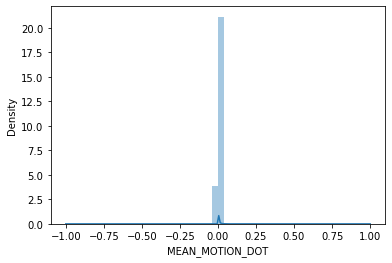

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(df['MEAN_MOTION_DOT']);

In [6]:
from pandas_profiling import ProfileReport

ModuleNotFoundError: No module named 'pandas_profiling'

## First model

In [10]:
import numpy as np

def create_index_map(df):
    '''
    This will create a map between an input record (for X_train) and
    a label record (for y_train) that will be used by the pytorch
    dataset class to dynamically build a dataset without taking up
    more space than is necessary.
    '''
    
    # ML Structure
    # Input:
    #  - Reference TLE Data (+ EPOCH)
    #  - Target EPOCH
    # Output:
    #  - Target TLE Data
    
    def groups(lst):
        arr = lst.copy()
        np.random.shuffle(arr)
        i=1
        if len(lst)<=1:
            return
        while True:
            if i==len(lst):
                yield tuple((arr[i-1],arr[0]))
                break
            else:
                yield tuple((arr[i-1],arr[i]))
                i+=1
    
    # For each unique NORAD, find all TLE indexes and generate
    # a list of combinations
    idx_pairs = []
    for norad in df['NORAD_CAT_ID'].unique():
        norad_idxs = df[df['NORAD_CAT_ID']==norad].index.values
        if len(norad_idxs > 1):
            idx_pairs.extend(groups(norad_idxs))
    idx_pairs = np.array(idx_pairs)
    
#     # Build our X/Y datasets
#     X_all = df.loc[idx_pairs[:,0]].reset_index()
#     Y_all = df.loc[idx_pairs[:,1]].reset_index()
    
#     # This will be the column that links x and y
#     key_columns = ['epoch_jd', 'epoch_fr']
#     target_columns = ['target_epoch_jd', 'target_epoch_fr']
#     X_all[target_columns] = Y_all[key_columns]
    
    return idx_pairs

%time idx_pairs = create_index_map(df)  # 16min - look at ways to improve this through parallelism/concurrency

Wall time: 10.6 s


In [11]:
# Test the dataset structure method
import torch

model_cols = ['MEAN_MOTION_DOT', 'MEAN_MOTION_DDOT', 'BSTAR', 'INCLINATION', 'RA_OF_ASC_NODE',
              'ECCENTRICITY', 'ARG_OF_PERICENTER', 'MEAN_ANOMALY', 'MEAN_MOTION', 'epoch_jd', 'epoch_fr']

tmp_df = df.iloc[:10][model_cols].copy()
t1 = torch.from_numpy(tmp_df.to_numpy())  # data
t2 = torch.tensor([(0,1),(1,2)])

index = 0
p = t2[index]
X = torch.cat((t1[p[0]], t1[p[1]][-2:]), 0)
y = t1[p[1]][:-2]
display(X)
display(y)

tensor([ 1.8010e-05,  0.0000e+00,  2.5919e-03,  3.4579e-01,  5.0043e-01,
         4.1309e-01,  7.3799e-01,  2.3966e-01, -4.0693e-01,  2.4531e+06,
         5.9639e-01,  2.4531e+06,  6.6644e-01], dtype=torch.float64)

tensor([-2.0000e-08,  0.0000e+00,  1.0000e-04,  4.0756e-01,  9.6025e-01,
         2.0657e-01,  7.5111e-01,  2.4636e-01, -5.0207e-01],
       dtype=torch.float64)

In [10]:
import torch
import torch.nn as nn
torch.manual_seed(0)

hiddenSize = 300
batchSize = 200
learningRate = 0.01
numEpochs = 10

model_cols = ['MEAN_MOTION_DOT', 'MEAN_MOTION_DDOT', 'BSTAR', 'INCLINATION', 'RA_OF_ASC_NODE',
              'ECCENTRICITY', 'ARG_OF_PERICENTER', 'MEAN_ANOMALY', 'MEAN_MOTION', 'epoch_jd', 'epoch_fr']

#device = torch.device('cpu')
device = torch.device('cuda')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, data, idx_pairs, device='cpu'):
        'Initialization'
        self.data = to_device(torch.from_numpy(data.to_numpy()).float(), device)
        self.idx_pairs = to_device(torch.from_numpy(idx_pairs).long(), device)

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.idx_pairs)

    def __getitem__(self, index):
        'Generates one sample of data'
        p = self.idx_pairs[index]
        
        # This will use the idx_pairs (x,y) to build the inputs(X) and labels (y)
        # output.  It adds the last 2 columns of y to X and removes them from y.
        X = torch.cat((self.data[p[0]], self.data[p[1]][-2:]), 0)
        y = self.data[p[1]][:-2]

        return X, y

In [11]:
class NNModel(nn.Module):
    def __init__(self, inputSize, outputSize, hiddenSize, activate=None):
        super().__init__()
        self.activate = nn.Sigmoid() if activate == "Sigmoid" else nn.Tanh() if activate == "Tanh" else nn.ReLU()
        self.layer1 = nn.Linear(inputSize, hiddenSize)
        self.layer2 = nn.Linear(hiddenSize, outputSize)

    def forward(self, X):
        hidden = self.activate(self.layer1(X))
        return self.layer2(hidden)
        
        
net = NNModel(len(model_cols) + 2, len(model_cols) - 2, hiddenSize)
to_device(net, device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(net.parameters(), lr=learningRate)

trainDataset = Dataset(df[model_cols], idx_pairs, device)
trainLoader = torch.utils.data.DataLoader(dataset=trainDataset,
                                          batch_size=batchSize,
                                          shuffle=True,
                                         )

In [12]:
%%time
print('>>> Beginning training!')
for epoch in range(numEpochs):
    for i, (inputs, labels) in enumerate(trainLoader):
        optimizer.zero_grad()
        # Forward propagation
        outputs = net(inputs)
        # Backpropagation
        loss = criterion(outputs, labels)
        loss.backward()
        # Gradient descent
        optimizer.step()
        # Logging
        if (i+1) % 1000 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {}'.format(epoch+1, numEpochs, i+1,
                                                                 len(trainDataset)//batchSize, loss))

>>> Beginning training!
Epoch [1/10], Step [1000/274498], Loss: 67.85113525390625
Epoch [1/10], Step [2000/274498], Loss: 61.399200439453125
Epoch [1/10], Step [3000/274498], Loss: 59.910133361816406
Epoch [1/10], Step [4000/274498], Loss: 55.3093376159668
Epoch [1/10], Step [5000/274498], Loss: 51.05797576904297
Epoch [1/10], Step [6000/274498], Loss: 47.72842025756836
Epoch [1/10], Step [7000/274498], Loss: 44.89704513549805
Epoch [1/10], Step [8000/274498], Loss: 43.87120819091797
Epoch [1/10], Step [9000/274498], Loss: 40.73126983642578
Epoch [1/10], Step [10000/274498], Loss: 39.8402099609375
Epoch [1/10], Step [11000/274498], Loss: 38.2437858581543
Epoch [1/10], Step [12000/274498], Loss: 36.390560150146484
Epoch [1/10], Step [13000/274498], Loss: 36.37118911743164
Epoch [1/10], Step [14000/274498], Loss: 35.300994873046875
Epoch [1/10], Step [15000/274498], Loss: 33.36863327026367
Epoch [1/10], Step [16000/274498], Loss: 34.209449768066406
Epoch [1/10], Step [17000/274498], Loss

KeyboardInterrupt: 

In [16]:
pd.DataFrame(idx_pairs,columns=['idx1','idx2']).to_csv(os.environ['GP_HIST_PATH'] + '/idx_pairs/train_idx_pairs.csv', index=False)

In [19]:
%time idx_pairs = pd.read_csv(os.environ['GP_HIST_PATH'] + '/idx_pairs/train_idx_pairs.csv').to_numpy()

Wall time: 7.57 s


In [18]:
idx_pairs

array([[15075076, 25553468],
       [25553468, 20818702],
       [20818702, 32231723],
       ...,
       [54898363, 54885991],
       [54885991, 54881418],
       [54881418, 54862939]], dtype=int64)